In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

# Introduction

La version exécutable, depuis un navigateur web, de ce rapport est disponible sur \url{http://mybinder.org/repo/dzamlo/tp_rng/}. C'est elle qui contient le code du TP. Pour exécuter tout le code, cliquez sur Cell->Run All. Si une partie du code est cachée, cliquez deux fois sur l'œil en haut à droite. Une version exécutable localement est incluse en pièce jointe de ce PDF mais elle nécessite l'installation de Jupyter\footnote{\url{http://jupyter.org/}}. 

# Génerateurs

## L’algorithme K

In [2]:
def k_next(x):
    y = x // 10**5
    for i in range(y+1):
        z = x // 10**4 % 10
        if z == 1 or z == 9:
            x = x*x // 10**3 % 10**6
        elif z == 2 or z == 5:
            x = 1001001 * x % 10**6
        elif z == 3:
            x = 10**3 * (x % 10**3) + x // 10**3 
        elif z == 4 or z == 8:
            if x < 10**4:
                x += 20469
            else:
                x= 10**6 - x
        elif z == 6 or z== 7:
            if x < 5 * 10**3:
                x = x + 5 * 10**3
    return x

def k_gen(x0):
    x = x0
    while True:
        x = k_next(x)
        yield x

On peut constater que malgré son côté compliqué ce générateur est en fait très mauvais. Après un nombre très réduit d'itération, il génère toujours le même nombre.

## Générateurs congruentiels linéaires


In [3]:
def lcg(a, c, m, x):
    return (a*x + c) % m

def lcg_gen(a, c, m, x0):
    x = x0
    while True:
        yield x
        x = lcg(a, c, m, x)


def lcg_n(a, c, m, n, x0):
    gen = lcg_gen(a, c, m, x0)
    for i in range(n):
        yield next(gen)


### Cycles

Toutes les valeurs générées $\in \mathbb{R}$ et seront $< m$ à cause du modulo. De ce fait il y un nombre fini de nombre qui peuvent être généré par ce générateur. Au bout d'un moment on générera donc forcement un nombre que l'on a déjà généré. La récurrence ne faisait référence qu'au nombre précédant, le nombre suivant sera le même que la dernière fois et ainsi de suite.

On se retrouvera dans la même situation pour tous générateurs dont l'état interne est fini (soit touts les générateurs de nombre pseudo aléatoire utilisé en pratique). Ainsi un générateur possédant $b$ bits d'états ne pourra pas avoir une période supérieure à $2^b$.

### Recherche de paramètres

In [4]:
def find_period_lcg(a, c, m, x0):
    values_idx = [-1 for _ in range(m)]
    gen = lcg_gen(a, c, m, x0)
    i = 0
    while True:
        x = next(gen)
        if values_idx[x] != -1:
            return i - values_idx[x]
        values_idx[x] = i
        i += 1
        

max_periods = []
m = 10
for a in range(m):
    for c in range(m):
        period = find_period_lcg(a, c, m, 0)
        if period == m:
            max_periods.append((a, c))

Pour $m = 10$, les paramètres $(a, c)$ qui donnent une période maximale (10) sont: {{max_periods}}. On peut constater que même s'ils donnent tous une période maximale, ces paramètres ne donnent pas des séquences de la même qualité. Par exemple (1,1) donnes les nombres dans l'ordre.

### RANDU

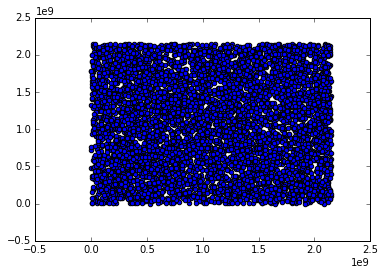

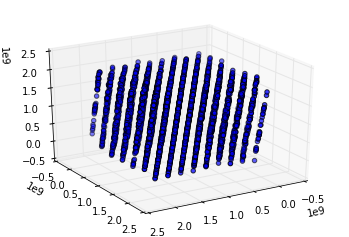

In [5]:
from mpl_toolkits.mplot3d import Axes3D
value_randu = list(lcg_n(65539, 0, 2**31, 12000, 123456789))

x = value_randu[:-1:2]
y = value_randu[1::2]
plt.scatter(x,y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(26, 59)
x = value_randu[:-2:3]
y = value_randu[1:-1:3]
z = value_randu[2::3]
ax.scatter(x,y,z);

On constate que les point se retrouvent dans 15 plans. Avec des vrais nombres aléatoires, cela n'arriverait pas. 

## Générateur de Stoll–Kirckpatrick


In [6]:
def stoll_kirckpatrick_gen():
    stoll_kirckpatrick_values = [int(l) for l in open("aleatoire250.txt")]
    while(True):
        value = stoll_kirckpatrick_values[-250] ^ stoll_kirckpatrick_values[-102]
        stoll_kirckpatrick_values.append(value)
        yield value
    

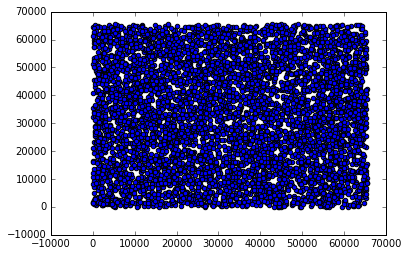

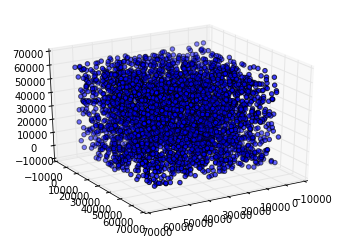

In [7]:
from mpl_toolkits.mplot3d import Axes3D
values_stoll_kirckpatrick = []
gen = stoll_kirckpatrick_gen()
while len(values_stoll_kirckpatrick) < 300000:
    v = next(gen)
    values_stoll_kirckpatrick.append(v)

values_stoll_kirckpatrick_plot=values_stoll_kirckpatrick[:12000]
x = values_stoll_kirckpatrick_plot[:-1:2]
y = values_stoll_kirckpatrick_plot[1::2]
plt.scatter(x,y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(26, 59)
x = values_stoll_kirckpatrick_plot[:-2:3]
y = values_stoll_kirckpatrick_plot[1:-1:3]
z = values_stoll_kirckpatrick_plot[2::3]
ax.scatter(x,y,z);

On ne constate pas le même problème qu'avec RANDU.

In [8]:
avg = np.average(values_stoll_kirckpatrick)
expected_avg = (2**16-1)/2

La moyenne théorique attendue est de $(2^{16}-1)/2$, soit {{expected_avg}}. La moyenne obtenue est de {{avg}}. Les valeurs sont plutôt proches.

# Calcul de $\pi$

Pour le calcul de $\pi$, on utilise une méthode de Monte-Carlo. Le but est d'avoir un événement dont la probabilité est lié à $\pi$. En simulant l'événement un grand nombre de fois, on peut approximer numériquement la probabilité que l'événement soit vrai. On utilise ensuite cette approximation pour calculer la valeur de $\pi$.

Dans notre cas on genere un point aléatoire dans un caré qui fait 1 de coté. On verfie ensuite si le point est dans le qurt de cerlce dont le centre est en (0,0). La probabilité que le point soit dans le cercle est égale à l'aire du quart de cercle divisé par l'air du caré, soit:

$$\frac{\frac{\pi}{4}}{1 \times 1} = \frac{\pi}{4}$$

En generant un nombre important de points, le nombre de point à l'interieur du quart de cercle divisé par le nombre de points générés tend vers la probabibilité qu'un point soit dans le quart de cerlce et donc vers $\frac{\pi}{4}$.


J'ai appliqué cette méthode avec 4 algorithmes de génération de nombre pseudo aléatoire: Mersenne Twister, RANDU, Stoll–Kirckpatrick, Sobol. Ce dernier est en fait une suite dites quasi aléatoire (ou suite à discrépance faible). J'ai trouvé intéressant de comparé le résultat avec ce type de générateur comparé aux autres générateurs.

Pour les generateurs Mersenne Twister et Sobol, j'ai utilisé des implémentations existantes.

L'algorithme K se retrouve très vite à ne générer qu'une unique valeur ad vitam æternam. Si cette valeur correspond à un point à l'intérieur du quart de cercle, la valeur calculée va tendre vers 4. Si au contraire elle correspond à un point à l'extérieur du quart de cercle, elle tendra vers 0. C'est pourquoi je n'ai pas inclus l'algorithme K dans le reste de l'analyse.

In [9]:
import random
import sobol_seq

def inside_circle(rng_iter):
    x = next(rng_iter)
    y = next(rng_iter)
    return x*x + y*y < 1

def calc_pi(rng_iter, points):
    l = [inside_circle(rng_iter) for _ in range(points)]
    return (np.cumsum(l) / range(1, len(l)+1)) * 4


# definition des generateur pseudoaléatoire comme des itérateur qui produisent des valeur ∈ [0, 1]

mt_rng = random.Random(x=0)
mt = (mt_rng.random() for _ in iter(int, 1))
randu = (x/2**31 for x in lcg_gen(65539, 0, 2**31, 123456789))
stoll_kirckpatrick = (x/65535 for x in stoll_kirckpatrick_gen())
def sobol_gen():
    seed = 0
    while True:
        xy, seed = sobol_seq.i4_sobol(2, seed)
        yield xy[0]
        yield xy[1]

# genearation des approximations de pi
N = 10000
values_mt = calc_pi(mt, N)
values_randu = calc_pi(randu, N)
values_stoll_kirckpatrick = calc_pi(stoll_kirckpatrick, N)
values_sobol = calc_pi(sobol_gen(), N)

def plot_pi(xlim=None, ylim=None):
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.xlabel("nombres de points")
    plt.ylabel("approximation de $\pi$")
    plt.plot(values_mt, label="Mersenne Twister")
    plt.plot(values_randu, label="RANDU")
    plt.plot(values_stoll_kirckpatrick, label="Stoll–Kirckpatrick")
    plt.plot(values_sobol, label="Sobol")
    plt.plot([np.pi for _ in range(N)], label="$\pi$")
    plt.legend(loc='best')

Apres {{N}} itérations, les valeurs que l'on trouve avec les diffférent generateurs sont:

\begin{itemize}
\item Mersenne Twister: {{values_mt[-1]}}
\item RANDU: {{values_randu[-1]}}
\item Stoll–Kirckpatrick: {{values_stoll_kirckpatrick[-1]}}
\item Sobol: {{values_sobol[-1]}}
\end{itemize}
 
Les valeurs que l'on trouvent varient en fonction de la graine utilisé pour le generateur ainsi que du nombre d'iterations.

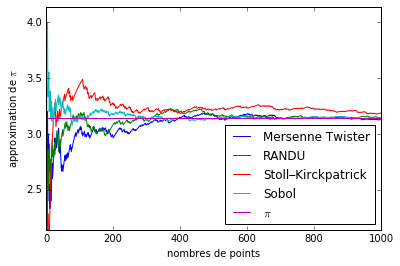

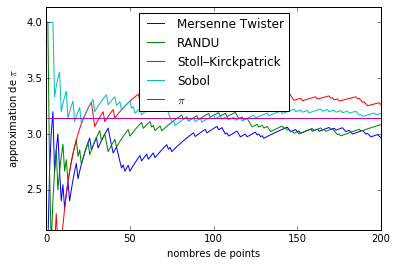

In [10]:
plot_pi(xlim=(0, 1000), ylim=(np.pi-1, np.pi+1))
plt.figure()
plot_pi(xlim=(0, 200), ylim=(np.pi-1, np.pi+1))

Sur ces deux figures, on peut constater qu'avec un nombre de points faible l'appoximation est peu precises et que plus on augmente le nombre de points, plus l'approxiamtion devient bonne.

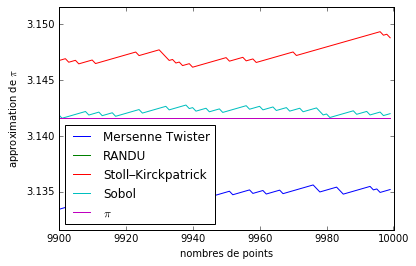

In [11]:
plot_pi(xlim=(N-100, N), ylim=(np.pi-0.01, np.pi+0.01))
max_var = max(max(values_mt[-100:]) - min(values_mt[-100:]),
max(values_randu[-100:]) - min(values_randu[-100:]),
max(values_stoll_kirckpatrick[-100:]) - min(values_stoll_kirckpatrick[-100:]),
max(values_sobol[-100:]) - min(values_sobol[-100:]),)

Sur cette figure on constate qu'avec un nombre important de points, les approximations sont plutot stable: sur les 100 dernière iterations, le generateur qui varie le plus varie de {{max_var}}.

On constate également que la suite quasi aléatoire est celle qui a donnée la meilleure approximation. 